## **Estimacion de precios de retail**

En el siguiente notebook se realiza la estimación de los precios de una tienda de retail utilizando técnicas de machine learning. Inicialmente se realiza un analisis exploratorio para identificar valores faltantes, nulos, duplicados y correlaciones, luego se aplican a transformaciones a las columnas para finalmente ser utilizados en un modelo. 

Dataset disponible en: https://www.kaggle.com/datasets/mohammadtalib786/retail-sales-dataset

### **1. Importación de librerias y de los datos**

In [212]:
# importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# herramientas
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# escalamiento y normalizacion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
# imputers
from sklearn.impute import SimpleImputer
# metricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
# mejoras
from sklearn.model_selection import GridSearchCV

In [153]:
# datos y conversion a dataframe
df = pd.read_csv('../data/retail_sales.csv')
print(df.head(10))

   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   
5               6  2023-04-25     CUST006  Female   45           Beauty   
6               7  2023-03-13     CUST007    Male   46         Clothing   
7               8  2023-02-22     CUST008    Male   30      Electronics   
8               9  2023-12-13     CUST009    Male   63      Electronics   
9              10  2023-10-07     CUST010  Female   52         Clothing   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30 

### **2. EDA**

En esta sección se busca realizar analizar y explorar el dataset.

In [92]:
# ultimas 5 filas del dataframe
print(df.tail(5))

     Transaction ID        Date Customer ID  Gender  Age Product Category  \
995             996  2023-05-16     CUST996    Male   62         Clothing   
996             997  2023-11-17     CUST997    Male   52           Beauty   
997             998  2023-10-29     CUST998  Female   23           Beauty   
998             999  2023-12-05     CUST999  Female   36      Electronics   
999            1000  2023-04-12    CUST1000    Male   47      Electronics   

     Quantity  Price per Unit  Total Amount  
995         1              50            50  
996         3              30            90  
997         4              25           100  
998         3              50           150  
999         4              30           120  


In [93]:
# info del retail_sales
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB
None


In [94]:
# estadisticas
print("Estadistica descriptiva del dataset")
print(df.describe())

Estadistica descriptiva del dataset
       Transaction ID         Age     Quantity  Price per Unit  Total Amount
count     1000.000000  1000.00000  1000.000000     1000.000000   1000.000000
mean       500.500000    41.39200     2.514000      179.890000    456.000000
std        288.819436    13.68143     1.132734      189.681356    559.997632
min          1.000000    18.00000     1.000000       25.000000     25.000000
25%        250.750000    29.00000     1.000000       30.000000     60.000000
50%        500.500000    42.00000     3.000000       50.000000    135.000000
75%        750.250000    53.00000     4.000000      300.000000    900.000000
max       1000.000000    64.00000     4.000000      500.000000   2000.000000


In [95]:
# tipos de datos
print(df.dtypes)

Transaction ID       int64
Date                object
Customer ID         object
Gender              object
Age                  int64
Product Category    object
Quantity             int64
Price per Unit       int64
Total Amount         int64
dtype: object


Como los datos seran sometidos a modelos, las columnas tipo object se mantendran de esta forma y no seran transformadas a string. En particular, la columna "date" si sera transformada a datetime. 

In [96]:
# string a datetime 
df['Date']=pd.to_datetime(df['Date'])
print(df.dtypes)

Transaction ID               int64
Date                datetime64[ns]
Customer ID                 object
Gender                      object
Age                          int64
Product Category            object
Quantity                     int64
Price per Unit               int64
Total Amount                 int64
dtype: object


In [97]:
# valores duplicados
duplicados = df.duplicated()

# contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [98]:
# dataframe
df.head(10)

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
5,6,2023-04-25,CUST006,Female,45,Beauty,1,30,30
6,7,2023-03-13,CUST007,Male,46,Clothing,2,25,50
7,8,2023-02-22,CUST008,Male,30,Electronics,4,25,100
8,9,2023-12-13,CUST009,Male,63,Electronics,2,300,600
9,10,2023-10-07,CUST010,Female,52,Clothing,4,50,200


Se verifica la consistencia de los datos categoricos y se convierten a minusculas.

In [99]:
# columnas categoricas a minusculas 
df['Gender'] = df['Gender'].str.lower()
df['Product Category'] = df['Product Category'].str.lower()

# valores unicos 
print("Valores únicos en la columna 'Gender':", df['Gender'].unique())
print("Valores únicos en la columna 'Product Category':", df['Product Category'].unique())

Valores únicos en la columna 'Gender': ['male' 'female']
Valores únicos en la columna 'Product Category': ['beauty' 'clothing' 'electronics']


En esta sección se analiza los valores faltantes en las columnas y se buscan métodos para rellenarlos en caso de ser necesario.

In [100]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Transaction ID,1000,0,0.0
Date,1000,0,0.0
Customer ID,1000,0,0.0
Gender,1000,0,0.0
Age,1000,0,0.0
Product Category,1000,0,0.0
Quantity,1000,0,0.0
Price per Unit,1000,0,0.0
Total Amount,1000,0,0.0


La distribucion de los datos se observa a continuacion.

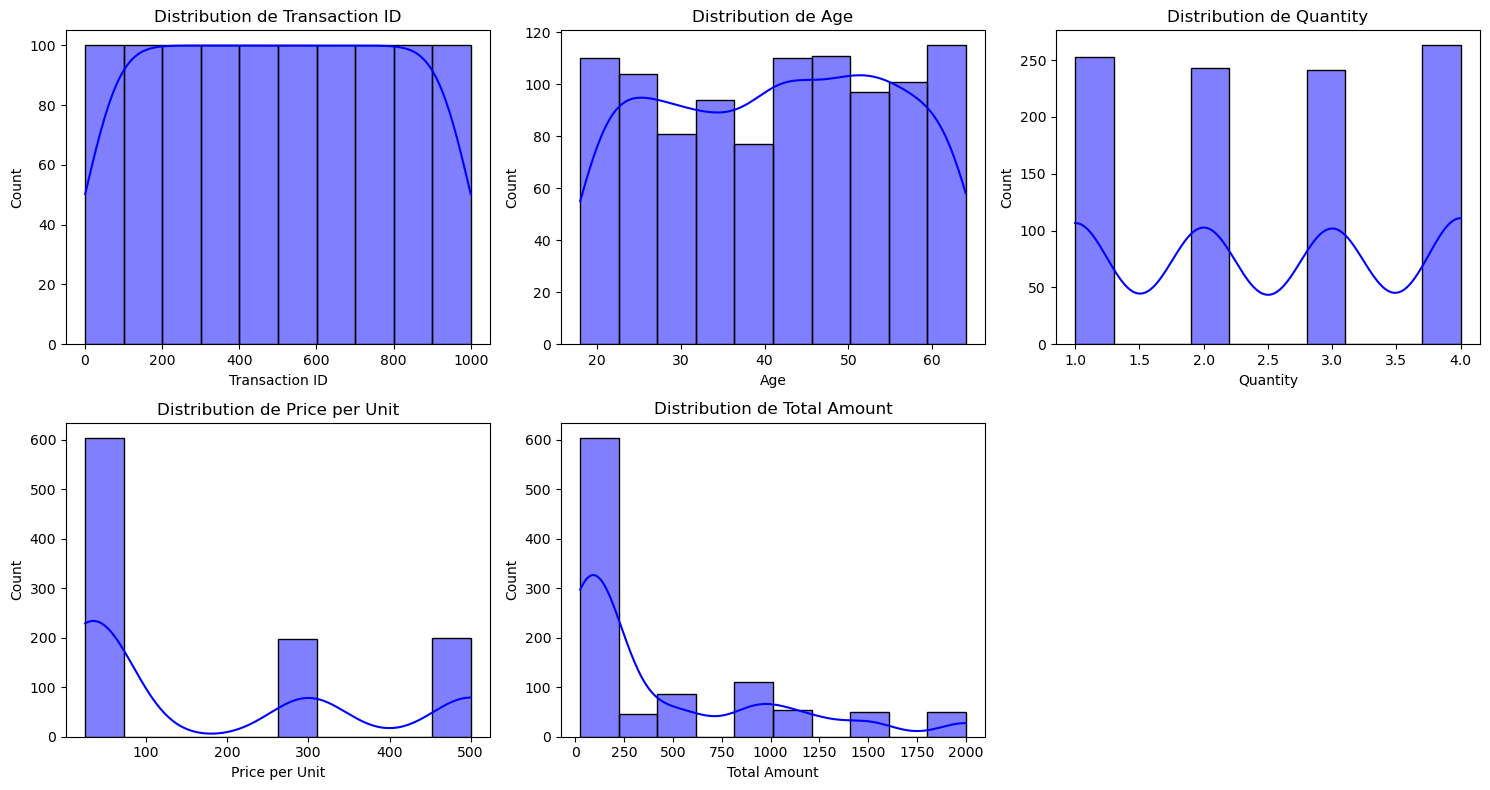

In [101]:
# numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# distribucion de los datos
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.histplot(df[col], kde=True, color="blue", bins=10)  
    plt.title(f"Distribution de {col}")
    plt.tight_layout()

plt.show()

Los outliers se visualizan a continuacion.

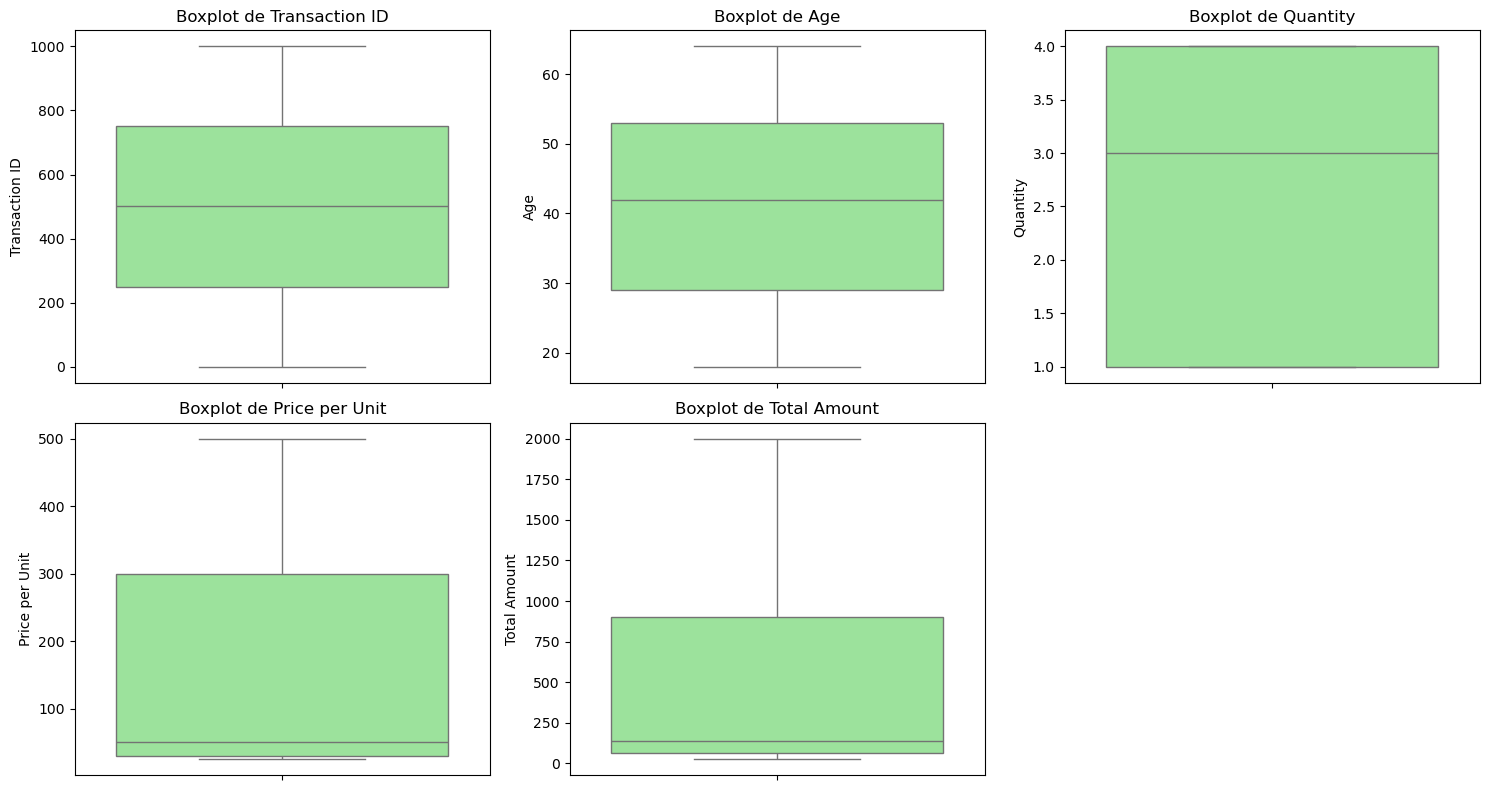

In [102]:
# numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# crear boxplots 
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.boxplot(y=df[col], color="lightgreen")
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()

plt.show()

Correlaciones entre las variables

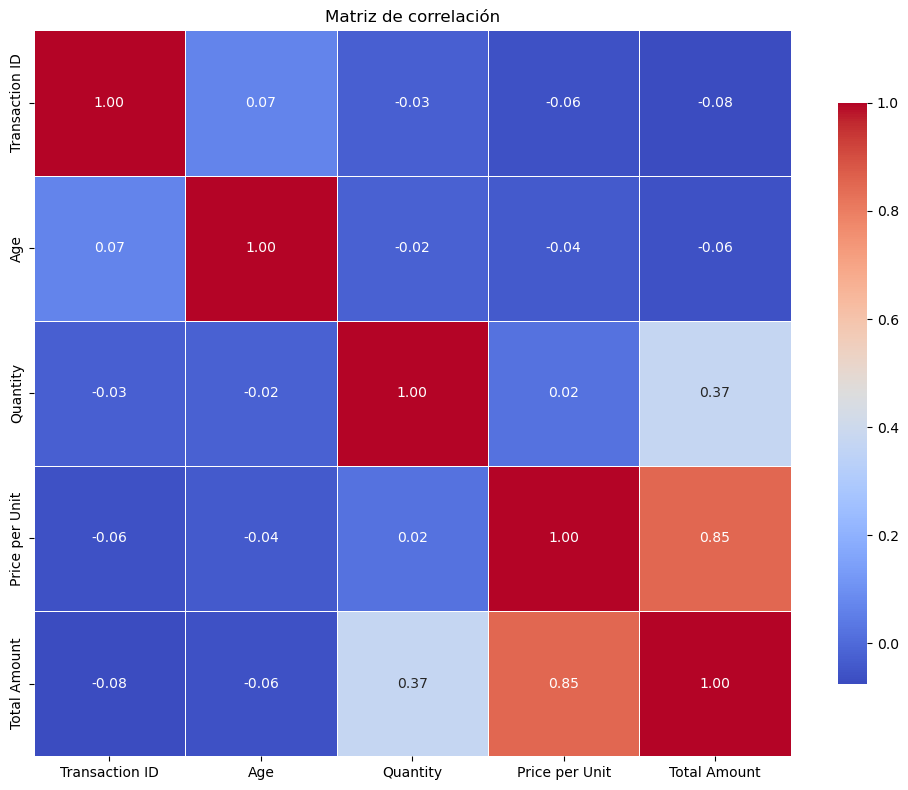

In [103]:
# variables numéricas
numerical_columns = df.select_dtypes(include=['int64','float64'])

# matriz de correlación
correlation_matrix = numerical_columns.corr()

# mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})
plt.title('Matriz de correlación')

# mostrar el grafico
plt.tight_layout()
plt.show()

### 3. **Preprocesamiento**

El objetivo de aplicar modelos a este set de datos es el de predecir el precio total de venta (total amount), por tanto se utilizan metricas de regresion para la validacion. 

Se realiza el preprocesamiento de los datos para luego ser utilizados en modelos.

In [154]:
df.head(5)

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [155]:
# variables categoricas y target
x = df.drop(columns=['Transaction ID','Customer ID', 'Total Amount','Date'])
y = df[['Total Amount']]

In [156]:
# verificacion 
print("Variables predictoras dimensiones" , x.shape)
print("Variable target dimensiones" , y.shape)

Variables predictoras dimensiones (1000, 5)
Variable target dimensiones (1000, 1)


In [157]:
# extraer columnas numericas
numerical_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x.select_dtypes(include=['object']).columns

# verificar
print("Features numericas: ", numerical_features)
print("Features categoricas: ", categorical_features)

Features numericas:  Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')
Features categoricas:  Index(['Gender', 'Product Category'], dtype='object')


A continuación, se crean transformadores para cada columna. No se realizara imputacion porque no hay datos faltantes, para las columnas numericas se aplicara el standard scaler y para las categoricas el onehotencoder.

In [158]:
# transformadores para cada subconjunto de columnas
# numerico
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# categorico
categoric_transformer = OneHotEncoder(handle_unknown='ignore')

In [159]:
# crear columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),  
        ('cat', categoric_transformer, categorical_features)  
    ]
)

Split de los datos y entrenamiento del modelo.

In [160]:
# split de los datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### **Modelo de regresion lineal**

Crear el pipeline con el modelo de regresion.

In [161]:
# pipeline 
model_reglineal = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', LinearRegression())  
])

In [162]:
# ajustar a los datos de entrenamiento
model_reglineal.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Product Category'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [163]:
# realizar predicciones
y_pred = model_reglineal.predict(x_test)

In [164]:
# evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 173.2085434679079
Error cuadrático medio (MSE): 41883.99204291286
Coeficiente de determinación (R²): 0.856918975519266


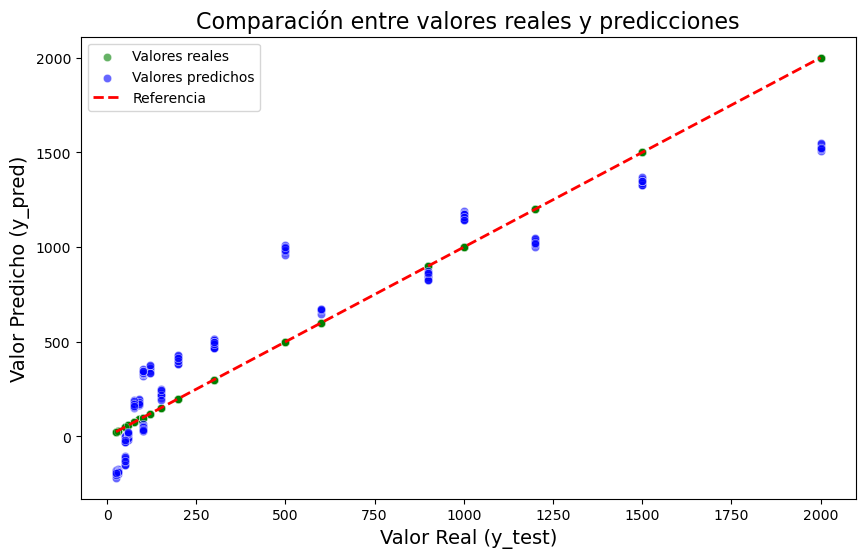

In [165]:
# grafico
plt.figure(figsize=(10, 6))

# scatter de valores en y_test
sns.scatterplot(x=y_test.values.flatten(), y=y_test.values.flatten(), color='green', label='Valores reales', alpha=0.6)

# scatter de valores en y_pred
sns.scatterplot(x=y_test.values.flatten(), y=y_pred.flatten(), color='blue', label='Valores predichos', alpha=0.6)

# linea de referencia
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Referencia')

#  configuraciones
plt.title('Comparación entre valores reales y predicciones', fontsize=16)
plt.xlabel('Valor Real (y_test)', fontsize=14)
plt.ylabel('Valor Predicho (y_pred)', fontsize=14)
plt.legend()

# grafico
plt.show()


### **Modelo KNN regressor**

Se adapta el flujo para aplicar KNN en el pipeline.

In [166]:
# split de los datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [167]:
# pipeline 
model_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', KNeighborsRegressor(n_neighbors=5)) 
])

In [168]:
# ajustar a los datos de entrenamiento
model_knn.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Product Category'], dtype='object'))])),
                ('regressor', KNeighborsRegressor())])

In [169]:
# realizar predicciones
y_pred = model_knn.predict(x_test)

In [170]:
# evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 59.82
Error cuadrático medio (MSE): 8376.06
Coeficiente de determinación (R²): 0.9713863176011446


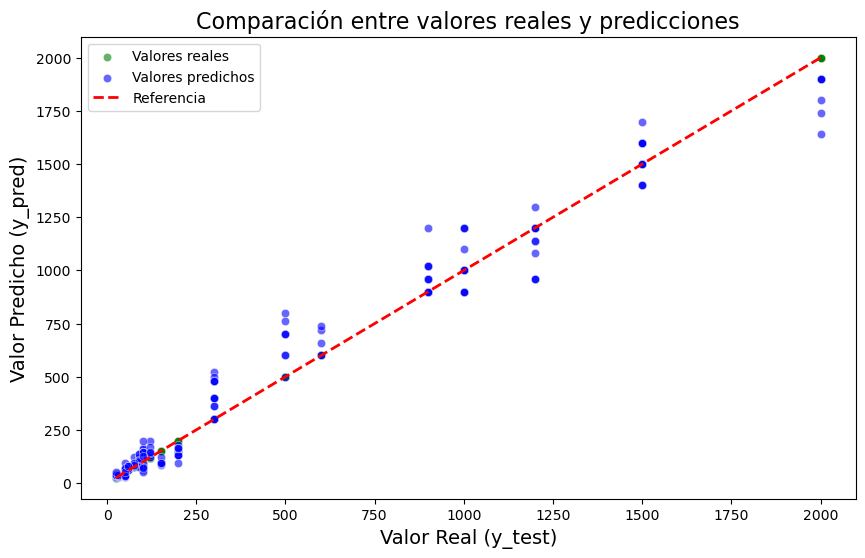

In [171]:
# grafico
plt.figure(figsize=(10, 6))

# scatter de valores en y_test
sns.scatterplot(x=y_test.values.flatten(), y=y_test.values.flatten(), color='green', label='Valores reales', alpha=0.6)

# scatter de valores en y_pred
sns.scatterplot(x=y_test.values.flatten(), y=y_pred.flatten(), color='blue', label='Valores predichos', alpha=0.6)

# linea de referencia
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Referencia')

#  configuraciones
plt.title('Comparación entre valores reales y predicciones', fontsize=16)
plt.xlabel('Valor Real (y_test)', fontsize=14)
plt.ylabel('Valor Predicho (y_pred)', fontsize=14)
plt.legend()

# grafico
plt.show()

### **Modelo Decision tree regressor**

Se adapta el flujo para arboles de decision en el pipeline.

In [182]:
# split de los datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [183]:
# pipeline 
model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5,ccp_alpha=0.01)) 
])

In [184]:
# ajustar a los datos de entrenamiento
model_tree.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Product Category'], dtype='object'))])),
                ('regressor',
                 DecisionTreeRegressor(ccp_alpha=0.01, max_depth=5,
                                       min_samples_leaf=5,
                                       min_samples_split=10))])

In [185]:
# realizar predicciones
y_pred = model_tree.predict(x_test)

In [186]:
# evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 0.0
Error cuadrático medio (MSE): 0.0
Coeficiente de determinación (R²): 1.0


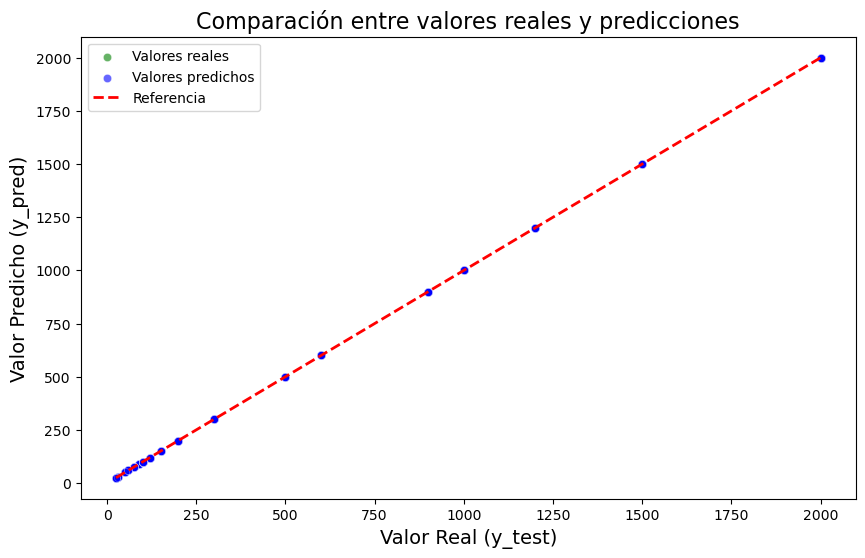

In [176]:
# grafico
plt.figure(figsize=(10, 6))

# scatter de valores en y_test
sns.scatterplot(x=y_test.values.flatten(), y=y_test.values.flatten(), color='green', label='Valores reales', alpha=0.6)

# scatter de valores en y_pred
sns.scatterplot(x=y_test.values.flatten(), y=y_pred.flatten(), color='blue', label='Valores predichos', alpha=0.6)

# linea de referencia
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Referencia')

#  configuraciones
plt.title('Comparación entre valores reales y predicciones', fontsize=16)
plt.xlabel('Valor Real (y_test)', fontsize=14)
plt.ylabel('Valor Predicho (y_pred)', fontsize=14)
plt.legend()

# grafico
plt.show()

El modelo de arbol de decision presenta un sobreajuste y se va buscar mejorar los parametros usando grid search.

In [188]:
# posibles valores de los parametros
param_grid = {
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 5],
    'regressor__ccp_alpha': [0.001, 0.01, 0.1]
}

In [189]:
# gird search 
grid_search = GridSearchCV(model_tree, param_grid, cv=5, scoring='neg_mean_squared_error')

In [190]:
# ajustar el modelo
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Gender', 'Product Category'], dtype='object'))])),
                                       ('regressor',
                                        DecisionTreeRegressor(ccp_alpha=0.01,
                                                              max_depth=5,
                                                              min_samples_leaf=5,
                                                              min_samples_split=10))]),
             param_grid={'regressor__ccp_alpha': [0.001, 0.01, 0.1],
                         'regressor__max_depth': [3, 5, 7, 10],
                         'regressor__min_samples_leaf': [1, 2, 5],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [191]:
# resultados
print("Mejores parámetros encontrados: ", grid_search.best_params_)
print("Mejor rendimiento (MSE): ", -grid_search.best_score_)

Mejores parámetros encontrados:  {'regressor__ccp_alpha': 0.001, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Mejor rendimiento (MSE):  -0.0


Aplicar lo obtenido al modelo

In [192]:
# pipeline 
model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=1,ccp_alpha=0.001)) 
])

In [193]:
# ajustar a los datos de entrenamiento
model_tree.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Product Category'], dtype='object'))])),
                ('regressor',
                 DecisionTreeRegressor(ccp_alpha=0.001, max_depth=5))])

In [194]:
# realizar predicciones
y_pred = model_tree.predict(x_test)

In [195]:
# evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 0.0
Error cuadrático medio (MSE): 0.0
Coeficiente de determinación (R²): 1.0


Sigue indicando un sobreajuste a los datos.

### **Modelo random forest regressor**

Se adapta el flujo para random forest en el pipeline.

In [177]:
# pipeline 
model_forest = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5, max_features='sqrt'))
])

In [178]:
# ajustar a los datos de entrenamiento
model_forest.fit(x_train, y_train)

c:\Users\Admin\miniconda3\envs\datascience\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Product Category'], dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=5, max_features='sqrt',
                                       min_samples_leaf=5,
                                       min_samples_split=10))])

In [179]:
# realizar predicciones
y_pred = model_forest.predict(x_test)

In [180]:
# evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 136.88200247383168
Error cuadrático medio (MSE): 36503.835636869364
Coeficiente de determinación (R²): 0.8752982715914881


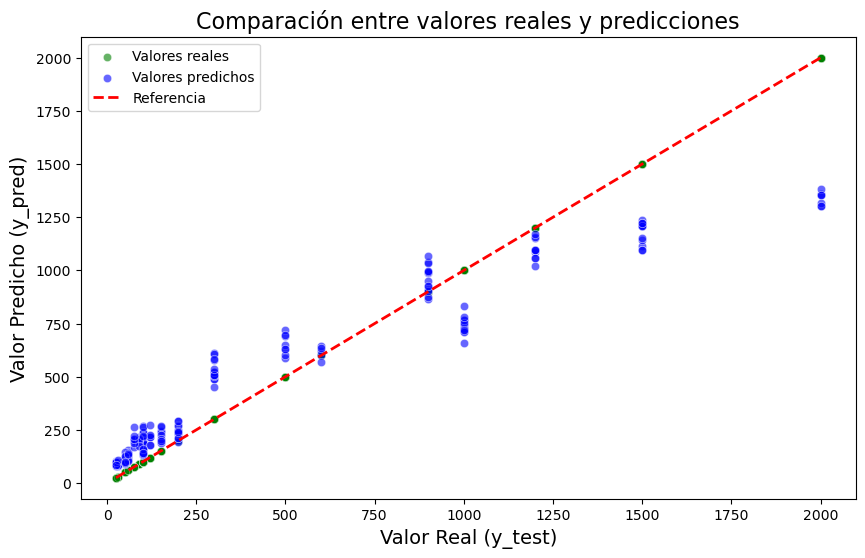

In [181]:
# grafico
plt.figure(figsize=(10, 6))

# scatter de valores en y_test
sns.scatterplot(x=y_test.values.flatten(), y=y_test.values.flatten(), color='green', label='Valores reales', alpha=0.6)

# scatter de valores en y_pred
sns.scatterplot(x=y_test.values.flatten(), y=y_pred.flatten(), color='blue', label='Valores predichos', alpha=0.6)

# linea de referencia
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Referencia')

#  configuraciones
plt.title('Comparación entre valores reales y predicciones', fontsize=16)
plt.xlabel('Valor Real (y_test)', fontsize=14)
plt.ylabel('Valor Predicho (y_pred)', fontsize=14)
plt.legend()

# grafico
plt.show()

### **Modelo LGBM**

In [197]:
# split de los datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [198]:
# pipeline 
model_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', LGBMRegressor())
])

In [200]:
# ajustar a los datos de entrenamiento
model_lgbm.fit(x_train, y_train.values.flatten())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 8
[LightGBM] [Info] Start training from score 454.062500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Product Category'], dtype='object'))])),
                ('regressor', LGBMRegressor())])

In [201]:
# realizar predicciones
y_pred = model_forest.predict(x_test)

In [202]:
# evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 136.88200247383168
Error cuadrático medio (MSE): 36503.835636869364
Coeficiente de determinación (R²): 0.8752982715914881


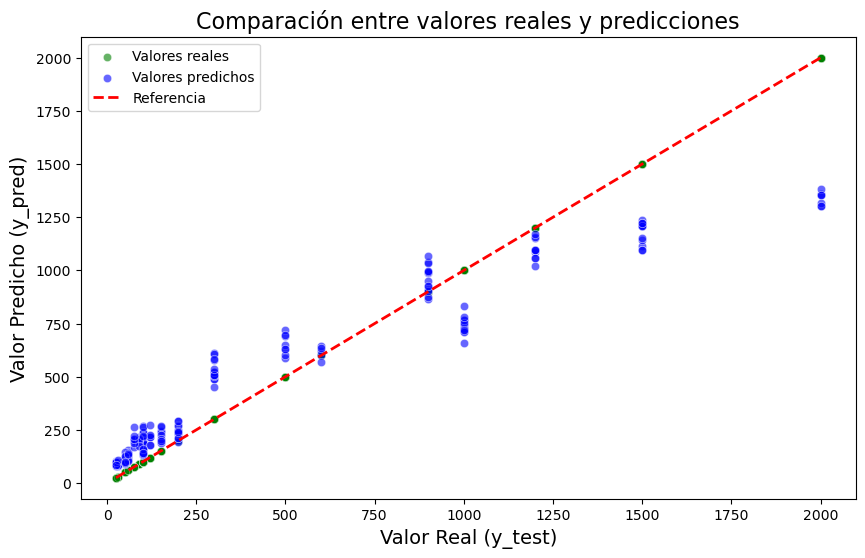

In [203]:
# grafico
plt.figure(figsize=(10, 6))

# scatter de valores en y_test
sns.scatterplot(x=y_test.values.flatten(), y=y_test.values.flatten(), color='green', label='Valores reales', alpha=0.6)

# scatter de valores en y_pred
sns.scatterplot(x=y_test.values.flatten(), y=y_pred.flatten(), color='blue', label='Valores predichos', alpha=0.6)

# linea de referencia
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Referencia')

#  configuraciones
plt.title('Comparación entre valores reales y predicciones', fontsize=16)
plt.xlabel('Valor Real (y_test)', fontsize=14)
plt.ylabel('Valor Predicho (y_pred)', fontsize=14)
plt.legend()

# grafico
plt.show()

### **Modelo Xgbboost**

In [205]:
# split de los datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [207]:
# pipeline 
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', XGBRegressor())
])

In [208]:
# ajustar a los datos de entrenamiento
model_xgb.fit(x_train, y_train.values.flatten())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Quantity', 'Price per Unit'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Gender', 'Product Category'], dtype='object'))])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsamp...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [209]:
# realizar predicciones
y_pred = model_forest.predict(x_test)

In [210]:
# evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 136.88200247383168
Error cuadrático medio (MSE): 36503.835636869364
Coeficiente de determinación (R²): 0.8752982715914881


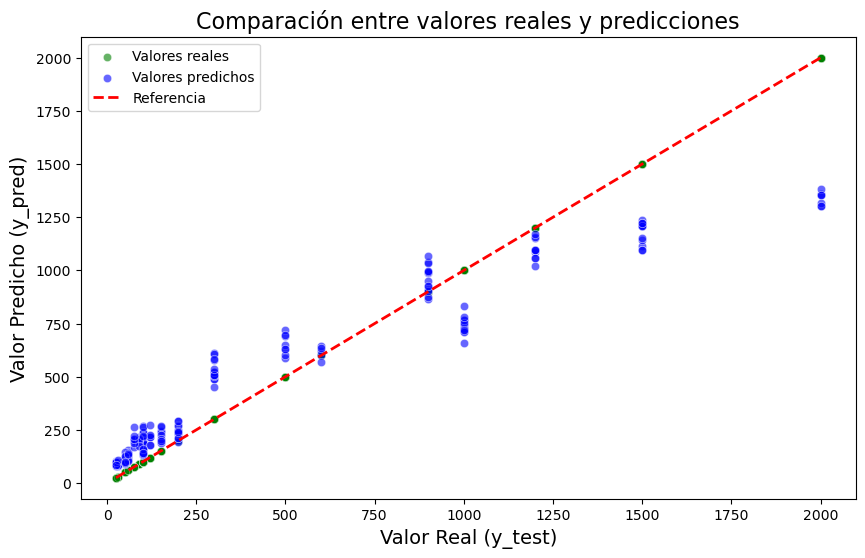

In [211]:
# grafico
plt.figure(figsize=(10, 6))

# scatter de valores en y_test
sns.scatterplot(x=y_test.values.flatten(), y=y_test.values.flatten(), color='green', label='Valores reales', alpha=0.6)

# scatter de valores en y_pred
sns.scatterplot(x=y_test.values.flatten(), y=y_pred.flatten(), color='blue', label='Valores predichos', alpha=0.6)

# linea de referencia
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Referencia')

#  configuraciones
plt.title('Comparación entre valores reales y predicciones', fontsize=16)
plt.xlabel('Valor Real (y_test)', fontsize=14)
plt.ylabel('Valor Predicho (y_pred)', fontsize=14)
plt.legend()

# grafico
plt.show()

### **Validacion cruzada**

In [217]:
# reg lineal
cv_scores_reglineal = cross_val_score(model_reglineal, x, y.values.flatten(), cv=5, scoring='neg_mean_squared_error')
print(f"CV MSE para modelo de regresión lineal: {-cv_scores_reglineal.mean()}")

# KNN
cv_scores_knn = cross_val_score(model_knn, x, y.values.flatten(), cv=5, scoring='neg_mean_squared_error')
print(f"CV MSE para KNN: {-cv_scores_knn.mean()}")

# decision tree
cv_scores_tree = cross_val_score(model_tree, x, y.values.flatten(), cv=5, scoring='neg_mean_squared_error')
print(f"CV MSE para árbol de decisión: {-cv_scores_tree.mean()}")

# random forest
cv_scores_forest = cross_val_score(model_forest, x, y.values.flatten(), cv=5, scoring='neg_mean_squared_error')
print(f"CV MSE para Random Forest: {-cv_scores_forest.mean()}")

# lgbm
cv_scores_lgbm = cross_val_score(model_lgbm, x, y.values.flatten(), cv=5, scoring='neg_mean_squared_error')
print(f"CV MSE para LightGBM: {-cv_scores_lgbm.mean()}")

# xgb
cv_scores_xgb = cross_val_score(model_xgb, x, y.values.flatten(), cv=5, scoring='neg_mean_squared_error')
print(f"CV MSE para XGBoost: {-cv_scores_xgb.mean()}")

CV MSE para modelo de regresión lineal: 46929.881557003115
CV MSE para KNN: 8860.117
CV MSE para árbol de decisión: -0.0
CV MSE para Random Forest: 43018.69654869448
CV MSE para LightGBM: 1.0864609066629782e-08
CV MSE para XGBoost: 1.0864609066629782e-08


Decision trees presenta un sobreajuste, tal que los datos ya fueron aprendidos completamente por el modelo y por esa razon da valores perfectos, esa misma condicion se presenta en lgbm y xgb, con valores de MSE iguales o cercanos a cero. El modelo de regresion tiene dificultades, mientas que el modelo de KNN es el que tiene un resultado mas razonable, evitando el sobreajuste. 